In [2]:
import multiprocessing as mp
import scipy.stats as stats
import pandas as pd
import numpy as np
import os

In [18]:
%load_ext rpy2.ipython

In [19]:
%%R
library(ggplot2)
library(RColorBrewer)
library(ggpubr)

In [76]:
associated_clones_cd8=pd.read_csv("CD8-Tcells/cd8.TXT", sep = '\t', index_col=0)
print("unique cdr3_b",len(set(associated_clones_cd8['cdr3_b_aa'])))
print("total cdr3_b",len(associated_clones_cd8['cdr3_b_aa']))
associated_clones_cd8=set(associated_clones_cd8['cdr3_b_aa'])

unique cdr3_b 2705
total cdr3_b 2717


In [10]:
summ=pd.read_csv("../../summary_table/clone_stat_top_5000.tsv", sep='\t', index_col=0)

In [11]:
def contingency_table_create(samples, clones_for_analyse, contingency_table):
    for sample_id in samples:
        status=summ.loc[sample_id,"status"]
        path=summ.loc[sample_id,"sample_full_path"]
        sample_clonotypes=pd.read_csv(str(path), sep='\t')
        sample_clonotypes=list(sample_clonotypes["cdr3aa"])
        found=set(sample_clonotypes)&set(clones_for_analyse)
        not_found=set(clones_for_analyse)-found
        if status=="COVID":
            contingency_table.loc[found, 'Found_COVID+'] += 1
            contingency_table.loc[not_found, 'nFound_COVID+'] += 1
        else:
            contingency_table.loc[found, 'Found_COVID-'] += 1
            contingency_table.loc[not_found, 'nFound_COVID-'] += 1       

In [12]:
def Fisher_extend_test(clone, contingency_table):
        local_clone=dict([(xT,0) for xT in ['oddsratio', 'pvalue']])
        # Create list for the current row 
        clone_values=list(contingency_table.loc[clone])
        a, b, c, d = clone_values[2], clone_values[0], clone_values[3], clone_values[1]
        сont_lst = [[a,b], [c,d]]
        oddsratio,pvalue = stats.fisher_exact(сont_lst)
        local_clone['oddsratio']=oddsratio
        local_clone['pvalue']=pvalue
        return (clone, local_clone)   

### Apply Fisher's exact test to data
### Get contingency table, odds ratio, fold change, p-value, 

#### Dataset: Adaptive

In [13]:
%%time
output_file_name="CD8-Tcells/Adaptive_fisher_test_result_top_5000.tsv"
clones_for_analyse=list(associated_clones_cd8)
dataset="Adaptive"

samples=list(summ.loc[(summ["Dataset"]=="Adaptive")|(summ["Dataset"]=="HIP")|(summ["Dataset"]=="KECK")].index)

df_col = [1]*len(clones_for_analyse)
contingency_table = pd.DataFrame({'Found_COVID-' : df_col, 'nFound_COVID-' : df_col, 'Found_COVID+' : df_col, 'nFound_COVID+' : df_col}, 
                  index = clones_for_analyse)
contingency_table.index.name='cdr3aa'


contingency_table_create(samples, clones_for_analyse, contingency_table=contingency_table)

def Fisher_extend_test_wr(clone, contingency_table=contingency_table):
    return Fisher_extend_test(clone, contingency_table)

print("START")    
pool = mp.Pool(processes = 10) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(Fisher_extend_test_wr, clones_for_analyse)
pool.close()
clone_statistic=dict(results)
print("DONE")


#----save results
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(['oddsratio', 'pvalue']))
    for clone in clone_statistic:
            out_file.write("\n")
            out_file.write(str(clone)+"\t")
            out_file.write("\t".join([str(clone_statistic[clone][stat]) for stat in ['oddsratio', 'pvalue']])) 

fisher_extend_test=pd.read_csv(output_file_name, sep = '\t', index_col=0) 

result = pd.concat([contingency_table, fisher_extend_test], axis=1)
result=result.sort_values('pvalue', kind='mergesort')
result["fold_change"]=result["Found_COVID+"]/result["Found_COVID-"]
result["dataset"]=dataset
result.to_csv(output_file_name, sep = '\t')               

START
DONE
CPU times: user 41.2 s, sys: 0 ns, total: 41.2 s
Wall time: 1min 4s


#### Dataset: FMBA

In [14]:
%%time
output_file_name="CD8-Tcells/FMBA_fisher_test_result_top_5000.tsv"
clones_for_analyse=list(associated_clones_cd8)
samples=list(summ.loc[summ["Dataset"]=="FMBA"].index)
dataset="FMBA"

df_col = [1]*len(clones_for_analyse)
contingency_table = pd.DataFrame({'Found_COVID-' : df_col, 'nFound_COVID-' : df_col, 'Found_COVID+' : df_col, 'nFound_COVID+' : df_col}, 
                  index = clones_for_analyse)
contingency_table.index.name='cdr3aa'


contingency_table_create(samples, clones_for_analyse, contingency_table=contingency_table)
    
def Fisher_extend_test_wr(clone, contingency_table=contingency_table):
    return Fisher_extend_test(clone, contingency_table)

print("START")    
pool = mp.Pool(processes = 10) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(Fisher_extend_test_wr, clones_for_analyse)
pool.close()
clone_statistic=dict(results)
print("DONE")


#----save results
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(['oddsratio', 'pvalue']))
    for clone in clone_statistic:
            out_file.write("\n")
            out_file.write(str(clone)+"\t")
            out_file.write("\t".join([str(clone_statistic[clone][stat]) for stat in ['oddsratio', 'pvalue']]))
            
            
fisher_extend_test=pd.read_csv(output_file_name, sep = '\t', index_col=0) 

result = pd.concat([contingency_table, fisher_extend_test], axis=1)
result=result.sort_values('pvalue', kind='mergesort')
result["fold_change"]=result["Found_COVID+"]/result["Found_COVID-"]
result["dataset"]=dataset
result.to_csv(output_file_name, sep = '\t')            

START
DONE
CPU times: user 23.1 s, sys: 0 ns, total: 23.1 s
Wall time: 37.6 s


In [15]:
result_ab=pd.read_csv("CD8-Tcells/Adaptive_fisher_test_result_top_5000.tsv", sep = '\t', index_col=0)
result_FMBA=pd.read_csv("CD8-Tcells/FMBA_fisher_test_result_top_5000.tsv", sep = '\t', index_col=0)
result=pd.concat([result_ab, result_FMBA])
result.to_csv("CD8-Tcells/Adaptive_FMBA_fisher_test_result_top_5000.tsv", sep = '\t')

### Volcano plot 
#### Volcano plot shows enrichment of COVID-associated clonotypes of repertoires from COVID patients in comparison to the healthy donor cohorts (x-axis) vs p-value (y-axis). Samples were previously normalized by the number of clonotypes (top 5000)


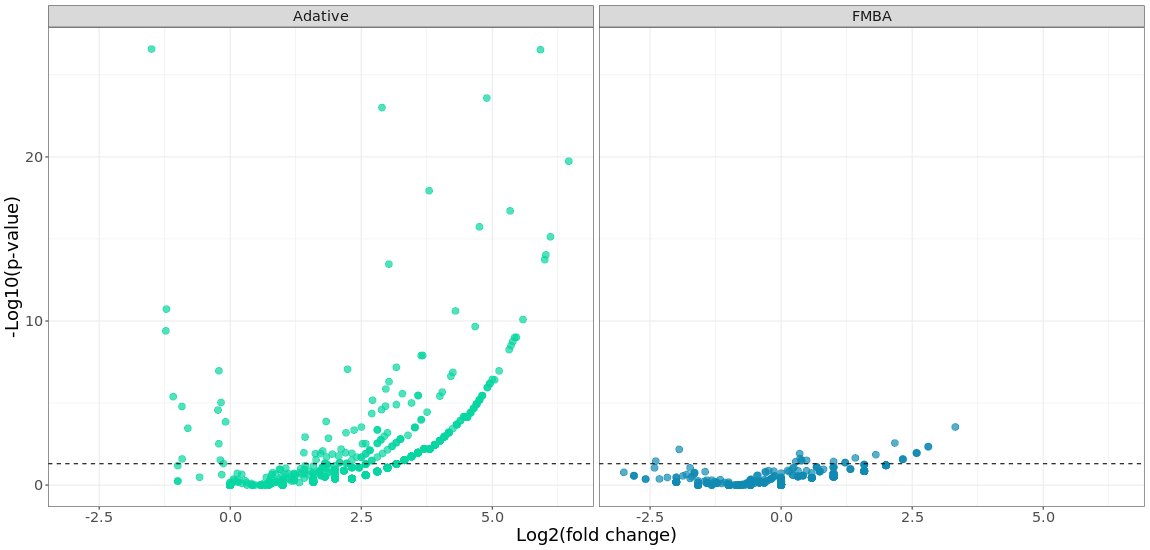

In [77]:
%%R -w 1150 -h 550
data=read.csv('../fisher_extend_test/thomas/fisher_test_result/Adaptive_FMBA_fisher_test_result_sorted_top_5000.tsv', sep="\t", header=TRUE)

h_line=-log10(0.05)
v_line=0
bp=ggplot(data, aes(x=log2(fold_change), y=-log10(pvalue), color=dataset)) +
geom_point(alpha = 0.7, size=3)   +
geom_hline(yintercept=h_line, linetype = "dashed") +
#geom_vline(xintercept=v_line, linetype = "dashed") +
scale_color_manual(values=c("#06d6a0", "#118ab2")) +
facet_wrap(~ dataset) +
labs(y= "-Log10(p-value)", x = "Log2(fold change)") +
theme_bw() +
theme(legend.position = "none", text=element_text(size=18,  family="Comic Sans MS"))
bp

### Volcano plot. Clonotypes colored according to clusters 
#### Enrichment of COVID-associated clonotypes in the Adaptive dataset. Clonotypes colored according to six largest clusters founded by Thomas et al


In [274]:
result_ab=pd.read_csv("../fisher_extend_test/thomas/fisher_test_result/Adaptive_fisher_test_result_sorted_top_5000.tsv", sep = '\t', index_col=0)
result_ab_clusters = pd.merge(result_ab, associated_clones_bls_cl_, left_index=True, right_index=True)
result_ab_clusters.to_csv("thomas/fisher_test_result/Adaptive_fisher_test_result_blsdist_cl_top_5000.tsv", sep = '\t')

In [275]:
result_fmba=pd.read_csv("../fisher_extend_test/thomas/fisher_test_result/FMBA_fisher_test_result_sorted_top_5000.tsv", sep = '\t', index_col=0)
result_fmba_clusters = pd.merge(result_fmba, associated_clones_bls_cl_, left_index=True, right_index=True)
result_fmba_clusters.to_csv("thomas/fisher_test_result/FMBA_fisher_test_result_blsdist_cl_top_5000.tsv", sep = '\t')

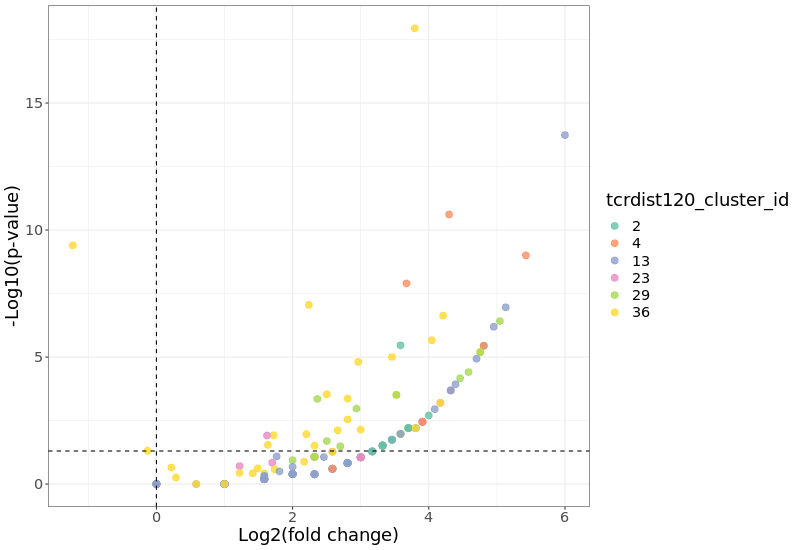

In [78]:
%%R -w 800 -h 550
data=read.csv('../fisher_extend_test/thomas/fisher_test_result/Adaptive_fisher_test_result_tcrdist_cl_top_5000.tsv', sep="\t", header=TRUE)
data$tcrdist120_cluster_id=as.factor(data$tcrdist120_cluster_id)
h_line=-log10(0.05)
v_line=0
bp=ggplot(data, aes(x=log2(fold_change), y=-log10(pvalue), color=tcrdist120_cluster_id)) +
geom_point(alpha = 0.8, size=3)   +
geom_hline(yintercept=h_line, linetype = "dashed") +
geom_vline(xintercept=v_line, linetype = "dashed") +
scale_color_brewer(palette = "Set2") +
labs(y= "-Log10(p-value)", x = "Log2(fold change)") +
theme_bw() +
theme(, text=element_text(size=18,  family="Comic Sans MS"))
bp

### Cumulative frequency. Boxplot (see "cumulative_frequency_boxplot.Rmd")

In [37]:
#-----calculate the weight of the clone in the sample-----

def get_clonotypes_frequences(sample_id, clones_for_analyse):
#------initialize by all zeroes------    
    local_clones_in_samples=dict([(xT,0) for xT in clones_for_analyse]) 
#------read clonotype tabel------
    path_to_folder_with_sample=sample_id[1] #path
    sample_name=sample_id[0]
    clonotype_file=pd.read_csv(str(path_to_folder_with_sample), sep='\t', index_col=0)
#------complete sequence match------    
    sample_clones=clonotype_file.index
    sample_public=set(clones_for_analyse)&set(sample_clones)
    sample_public_freq=clonotype_file.loc[sample_public, "freq"].to_dict() 
    local_clones_in_samples.update(sample_public_freq) 
    return (sample_name, local_clones_in_samples)

In [39]:
%%time
output_folder="CD8-Tcells/boxplots"
output_file_name=output_folder+"/"+"AB_FMBA_top_5000AA.tsv"
public_clones=associated_clones_cd8

#----read sample names-----
samples=list(zip(summ["sample_full_path"].index,summ["sample_full_path"]))

#-----make output folder-----
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass

#----find fraction of clonotypes of interest in samples------
def get_clonotypes_frequences_wrapper(sample_id, clones_for_analyse=public_clones):
    return get_clonotypes_frequences(sample_id, clones_for_analyse=clones_for_analyse)

#-----multiprocessing-----
print("START")    
pool = mp.Pool(processes = (mp.cpu_count()-20)) 
results=pool.map(get_clonotypes_frequences_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#-----save results-----
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(public_clones))
    for sample_name in clones_in_samples:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in public_clones])) 

CD8-Tcells/boxplots
START
DONE
CPU times: user 4.42 s, sys: 1.6 s, total: 6.02 s
Wall time: 13.9 s


In [43]:
cd8_freq=pd.read_csv("CD8-Tcells/boxplots/AB_FMBA_top_5000AA.tsv", sep='\t', index_col=0)

In [68]:
Adaptive=set(summ.loc[summ['Dataset']=='Adaptive'].index) 
HIP=set(summ.loc[summ['Dataset']=='HIP'].index) 
KECK=set(summ.loc[summ['Dataset']=='KECK'].index) 
FMBA_COVID=set(summ.loc[(summ['Dataset']=='FMBA')&(summ['status']=='COVID')].index) 
FMBA_HEALTHY=set(summ.loc[(summ['Dataset']=='FMBA')&(summ['status']=='HEALTHY')].index) 
FMBA_PRECOVID=set(summ.loc[(summ['Dataset']=='FMBA')&(summ['status']=='PRECOVID')].index)
dataset_AB=set(summ.loc[(summ["Dataset"]=="Adaptive")|(summ["Dataset"]=="HIP")|(summ["Dataset"]=="KECK")].index)
dataset_fmba=set(summ.loc[summ["Dataset"]=="FMBA"].index)

COVID_SUM=cd8_freq.sum(axis=1).to_frame(name="WEIGHT_SUM")

COVID_SUM.loc[COVID_SUM.index.isin(Adaptive) , "COHORT"]="Adaptive"
COVID_SUM.loc[COVID_SUM.index.isin(HIP) , "COHORT"]="HIP"
COVID_SUM.loc[COVID_SUM.index.isin(KECK) , "COHORT"]="KECK"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_COVID) , "COHORT"]="fmba_healthy"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_HEALTHY) , "COHORT"]="fmba_covid"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_PRECOVID) , "COHORT"]="precovid"
COVID_SUM.loc[COVID_SUM.index.isin(dataset_AB) , "dataset"]="Adaptive"
COVID_SUM.loc[COVID_SUM.index.isin(dataset_fmba) , "dataset"]="FMBA"
COVID_SUM=COVID_SUM.dropna()
COVID_SUM.to_csv("CD8-Tcells/boxplots/AB_FMBA_weighted_sum_top_5000AA.tsv", sep="\t")